<a href="https://colab.research.google.com/github/Noah-To/AIAB/blob/main/RenewAIABCW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# cell 1 importing library and random seed for reproducibility
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import copy

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
# cell 2 base cartpole environment

class BaseEnvironment:
    def __init__(self, env_name="CartPole-v1", max_steps=200, seed=None, render_mode=None):
        self.env_name = env_name
        self.max_steps = max_steps
        self.seed = seed
        self.render_mode = render_mode
        self.steps = 0
        self.env = gym.make(env_name, render_mode=render_mode)

        if seed is not None:
            self.env.reset(seed=seed)

    def reset(self):
        obs, _ = self.env.reset(seed=self.seed)
        self.steps = 0
        return obs

    def step(self, action):
        obs, reward, terminated, truncated, _ = self.env.step(action)
        self.steps += 1
        done = terminated or truncated or self.steps >= self.max_steps
        return obs, reward, done

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()


In [3]:
# cell 3: GA Agent

class GAAgentSimple:
    def __init__(self, input_dim=4):
        self.input_dim = input_dim
        self.num_genes = input_dim + 1  # 4 weights + 1 bias
        self.weights = torch.randn(input_dim, dtype=torch.float32)
        self.bias = torch.randn(1, dtype=torch.float32)

    def set_genes(self, genes):
        self.weights = torch.tensor(genes[:self.input_dim], dtype=torch.float32)
        self.bias = torch.tensor(genes[self.input_dim:], dtype=torch.float32)

    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32)
        return torch.dot(self.weights, obs) + self.bias

    def get_action(self, obs):
        return 1 if self.forward(obs).item() > 0 else 0


In [4]:
# cell 4: GA Solver

class GASolver:
    def __init__(self, env, agent_class=GAAgentSimple, pop_size=10,
                 mutation_std=0.1, crossover_rate=0.8, tournament_size=3, generations=500):
        self.env = env
        self.agent_class = agent_class
        self.pop_size = pop_size
        self.mutation_std = mutation_std
        self.crossover_rate = crossover_rate
        self.tournament_size = tournament_size
        self.generations = generations

        # Create agents and random initial population (genotypes)
        self.agents = [agent_class() for _ in range(pop_size)]
        self.num_genes = self.agents[0].num_genes
        self.population = np.random.randn(pop_size, self.num_genes)
        self.fitness_history = []

    def evaluate_agent(self, agent):
        obs = self.env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(obs)
            obs, reward, done = self.env.step(action)
            total_reward += reward
        return total_reward

    def evaluate_population(self):
        fitness = np.zeros(self.pop_size)
        for i, agent in enumerate(self.agents):
            agent.set_genes(self.population[i])
            fitness[i] = self.evaluate_agent(agent)
        return fitness

    def tournament_selection(self, fitness):
        candidates = np.random.choice(self.pop_size, self.tournament_size, replace=False)
        best_idx = candidates[np.argmax(fitness[candidates])]
        return self.population[best_idx].copy()

    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.num_genes)
            child1 = np.concatenate((parent1[:point], parent2[point:]))
            child2 = np.concatenate((parent2[:point], parent1[point:]))
            return child1, child2
        else:
            return parent1.copy(), parent2.copy()

    def mutate(self, genes):
        noise = np.random.normal(0, self.mutation_std, size=self.num_genes)
        mask = np.random.rand(self.num_genes) < 0.1  # 10% mutation rate
        genes[mask] += noise[mask]
        return np.clip(genes, -4, 4)  # clip to avoid overflow

    def train(self):
        best_fitness = -np.inf
        best_genotype = None

        for gen in range(self.generations):
            fitness = self.evaluate_population()

            # Save best solution
            gen_best = np.max(fitness)
            if gen_best > best_fitness:
                best_fitness = gen_best
                best_genotype = self.population[np.argmax(fitness)].copy()

            # Elitism: carry over best
            new_pop = [best_genotype.copy()]
            while len(new_pop) < self.pop_size:
                p1 = self.tournament_selection(fitness)
                p2 = self.tournament_selection(fitness)
                c1, c2 = self.crossover(p1, p2)
                c1 = self.mutate(c1)
                if len(new_pop) < self.pop_size:
                    c2 = self.mutate(c2)
                    new_pop.extend([c1, c2])
                else:
                    new_pop.append(c1)

            self.population = np.array(new_pop[:self.pop_size])
            self.fitness_history.append(best_fitness)

            if gen % 50 == 0:
                print(f"[GA] Generation {gen}: Best Fitness = {best_fitness:.2f}")

        self.best_genotype = best_genotype  # Save best for testing


[GA] Generation 0: Best Fitness = 65.00
[GA] Generation 50: Best Fitness = 200.00


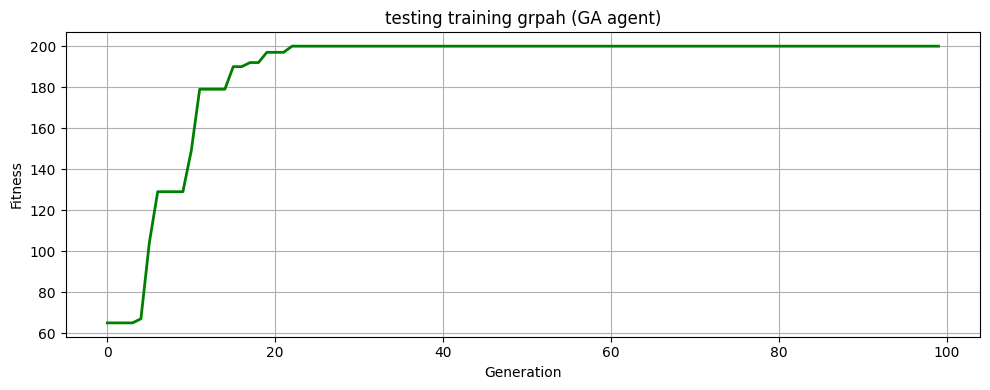

In [5]:
# cell 5 GA Test Run with Clean Line Plot
env = BaseEnvironment(seed=SEED)
ga_solver = GASolver(env, generations=100)

# Train GA agent
ga_solver.train()

# Plot best fitness over generations
plt.figure(figsize=(10, 4))
plt.plot(ga_solver.fitness_history, color='green', linewidth=2)
plt.title("testing training grpah (GA agent)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Cell 6: RLAgent – Policy Gradient Version

# A simple neural policy using two linear layers with ReLU and Softmax
class RLAgent(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=32, learning_rate=1e-3):
        super(RLAgent, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, act_dim)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs = self.forward(state)
        action = torch.multinomial(probs, num_samples=1).item()
        return action, torch.log(probs[action])


In [7]:
# Cell 7: RLSolver – Policy Gradient Training Loop

class RLSolver:
    def __init__(self, env, agent, gamma=0.99):
        self.env = env
        self.agent = agent
        self.gamma = gamma
        self.reward_history = []

    def train(self, episodes=1000):
        for episode in range(episodes):
            log_probs = []
            rewards = []

            state = self.env.reset()
            done = False

            while not done:
                action, log_prob = self.agent.get_action(state)
                next_state, reward, done = self.env.step(action)

                log_probs.append(log_prob)
                rewards.append(reward)
                state = next_state

            # Compute discounted returns
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)

            returns = torch.tensor(returns)
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # normalize

            # Compute policy gradient loss
            policy_loss = []
            for log_prob, R in zip(log_probs, returns):
                policy_loss.append(-log_prob * R)

            self.agent.optimizer.zero_grad()
            loss = torch.stack(policy_loss).sum()
            loss.backward()
            self.agent.optimizer.step()

            total_reward = sum(rewards)
            self.reward_history.append(total_reward)

            if episode % 50 == 0:
                print(f"[RL] Episode {episode}: Reward = {total_reward}")


[RL] Episode 0: Reward = 16.0
[RL] Episode 50: Reward = 47.0
[RL] Episode 100: Reward = 17.0
[RL] Episode 150: Reward = 21.0
[RL] Episode 200: Reward = 59.0
[RL] Episode 250: Reward = 56.0
[RL] Episode 300: Reward = 36.0
[RL] Episode 350: Reward = 61.0
[RL] Episode 400: Reward = 107.0
[RL] Episode 450: Reward = 64.0
[RL] Episode 500: Reward = 79.0
[RL] Episode 550: Reward = 54.0
[RL] Episode 600: Reward = 170.0
[RL] Episode 650: Reward = 181.0
[RL] Episode 700: Reward = 101.0
[RL] Episode 750: Reward = 200.0
[RL] Episode 800: Reward = 200.0
[RL] Episode 850: Reward = 200.0
[RL] Episode 900: Reward = 200.0
[RL] Episode 950: Reward = 200.0


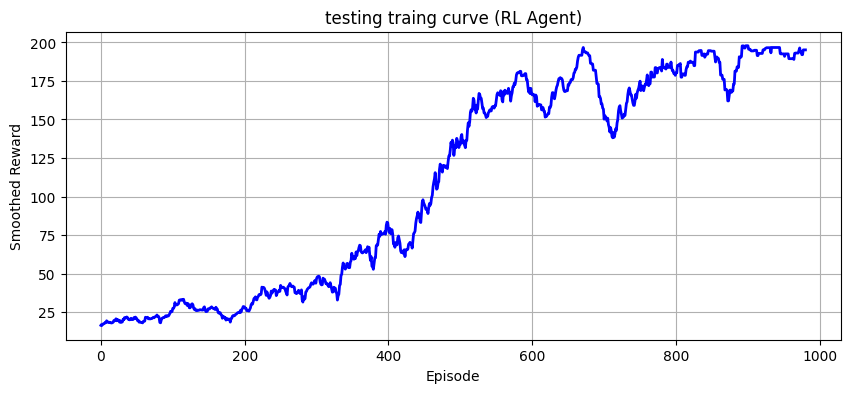

In [8]:
# Cell 8: RL Training and Reward Curve

env = BaseEnvironment(seed=SEED)
agent = RLAgent(obs_dim=4, act_dim=2)
solver = RLSolver(env, agent)
solver.train(episodes=1000)

# Smoothed reward curve after training the RL agent
window = 20
rewards = np.array(solver.reward_history)  # From the new RLSolver

if len(rewards) < window:
    print(f"Not enough data to smooth with window={window}. Showing raw curve.")
    rolling = rewards
else:
    rolling = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 4))
plt.plot(rolling, color='blue', linewidth=2)
plt.title("testing traing curve (RL Agent)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.show()


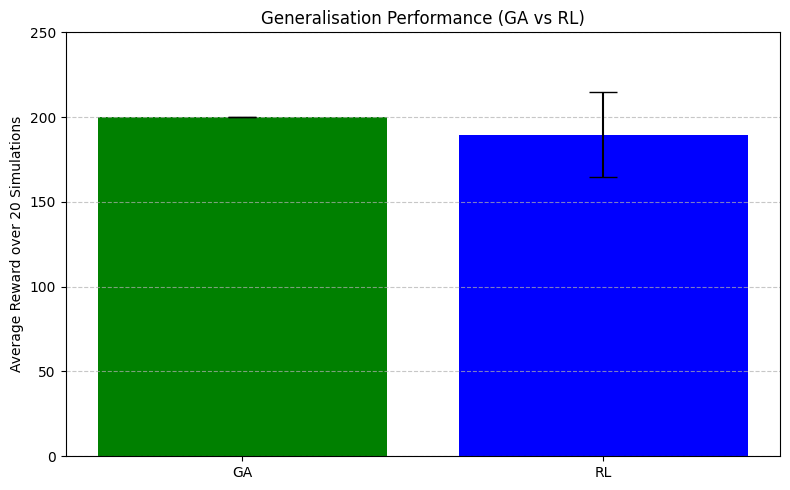

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- GA Performance Evaluation ---

def test_best_ga_agent(agent_class, best_genotype, env, trials=20):
    rewards = []
    agent = agent_class()
    agent.set_genes(best_genotype)
    for _ in range(trials):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.get_action(obs)
            obs, reward, done = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

# --- RL Performance Evaluation ---

def test_trained_rl_agent(trained_agent, env, trials=20):
    rewards = []
    for _ in range(trials):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = trained_agent.get_action(obs)
            obs, reward, done = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return np.array(rewards)

# --- Run Evaluation ---

trials = 20
ga_env = BaseEnvironment(seed=SEED)
rl_env = BaseEnvironment(seed=SEED)

ga_rewards = test_best_ga_agent(GAAgentSimple, ga_solver.best_genotype, ga_env, trials)
rl_rewards = test_trained_rl_agent(agent, rl_env, trials)

# --- Combined Bar Chart with Error Bars ---

means = [np.mean(ga_rewards), np.mean(rl_rewards)]
stds = [np.std(ga_rewards), np.std(rl_rewards)]

plt.figure(figsize=(8, 5))
bars = plt.bar(["GA", "RL"], means, yerr=stds, capsize=10, color=['green', 'blue'])
plt.ylabel("Average Reward over 20 Simulations")
plt.title("Generalisation Performance (GA vs RL)")
plt.ylim(0, 250)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Testing GA with mutation_std = 0.01
[GA] Generation 0: Best Fitness = 101.00
[GA] Generation 50: Best Fitness = 200.00

Testing GA with mutation_std = 0.05
[GA] Generation 0: Best Fitness = 50.00
[GA] Generation 50: Best Fitness = 96.00

Testing GA with mutation_std = 0.1
[GA] Generation 0: Best Fitness = 35.00
[GA] Generation 50: Best Fitness = 124.00

Testing GA with mutation_std = 0.2
[GA] Generation 0: Best Fitness = 22.00
[GA] Generation 50: Best Fitness = 62.00


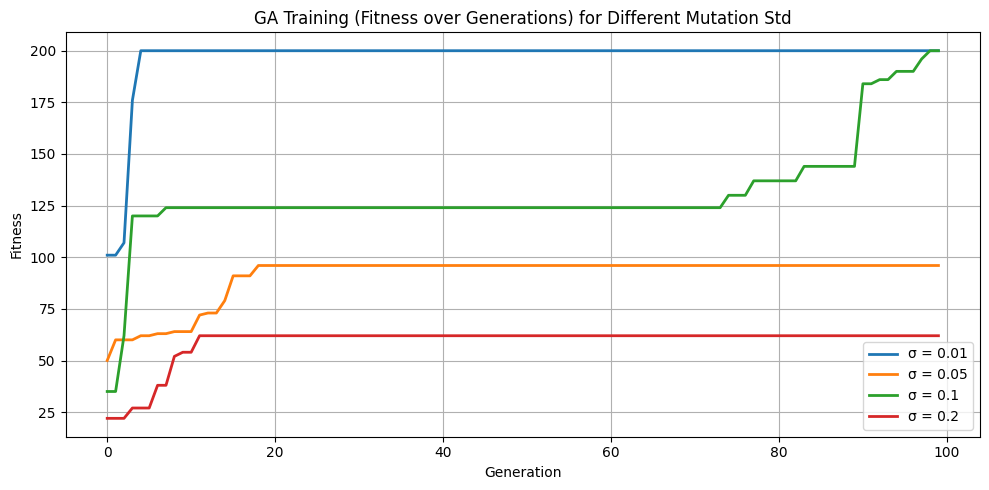

In [16]:
# cell 9a parameter testing GA mutation

mutation_values = [0.01, 0.05, 0.1, 0.2]
colors = ['red', 'blue', 'green', 'orange']
fitness_curves = {}

for i, mut_std in enumerate(mutation_values):
    print(f"\nTesting GA with mutation_std = {mut_std}")
    env = BaseEnvironment(seed=SEED)
    solver = GASolver(env, mutation_std=mut_std, generations=100)
    solver.train()
    fitness_curves[mut_std] = solver.fitness_history
    env.close()

# Plot
plt.figure(figsize=(10, 5))
for mut_std, curve in fitness_curves.items():
    plt.plot(curve, label=f"σ = {mut_std}", linewidth=2)
plt.title("GA Training (Fitness over Generations) for Different Mutation Std")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Testing GA with crossover_rate = 0.0
[GA] Generation 0: Best Fitness = 17.00
[GA] Generation 50: Best Fitness = 149.00

Testing GA with crossover_rate = 0.4
[GA] Generation 0: Best Fitness = 57.00
[GA] Generation 50: Best Fitness = 105.00

Testing GA with crossover_rate = 0.8
[GA] Generation 0: Best Fitness = 15.00
[GA] Generation 50: Best Fitness = 160.00

Testing GA with crossover_rate = 1.0
[GA] Generation 0: Best Fitness = 200.00
[GA] Generation 50: Best Fitness = 200.00


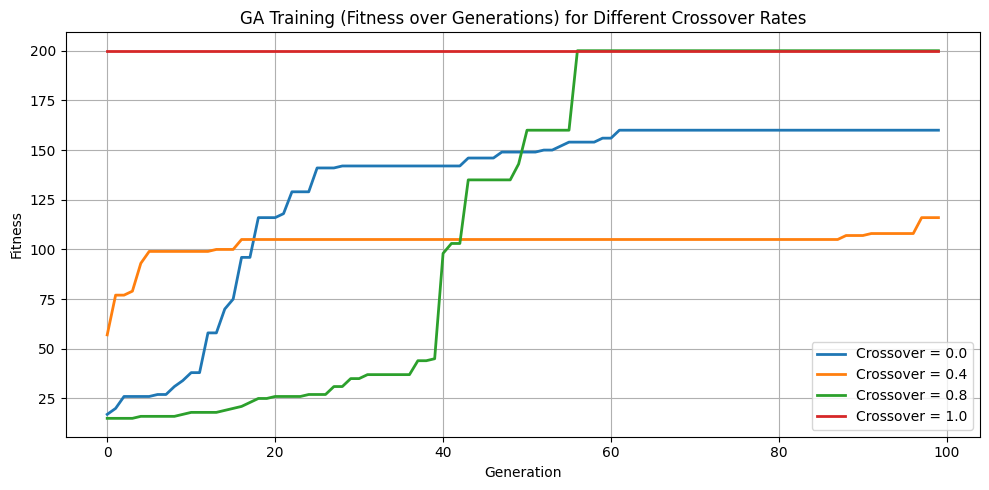

In [20]:
# cell 9b parameter testing GA crossover

crossover_values = [0.0, 0.4, 0.8, 1.0]
colors = ['purple', 'brown', 'cyan', 'black']
fitness_curves = {}

for i, cr in enumerate(crossover_values):
    print(f"\nTesting GA with crossover_rate = {cr}")
    env = BaseEnvironment(seed=SEED)
    solver = GASolver(env, crossover_rate=cr, generations=100)
    solver.train()
    fitness_curves[cr] = solver.fitness_history
    env.close()

# Plot
plt.figure(figsize=(10, 5))
for cr, curve in fitness_curves.items():
    plt.plot(curve, label=f"Crossover = {cr}", linewidth=2)
plt.title("GA Training (Fitness over Generations) for Different Crossover Rates")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Testing GA with tournament_size = 2
[GA] Generation 0: Best Fitness = 16.00
[GA] Generation 50: Best Fitness = 26.00

Testing GA with tournament_size = 3
[GA] Generation 0: Best Fitness = 189.00
[GA] Generation 50: Best Fitness = 200.00

Testing GA with tournament_size = 5
[GA] Generation 0: Best Fitness = 39.00
[GA] Generation 50: Best Fitness = 160.00

Testing GA with tournament_size = 10
[GA] Generation 0: Best Fitness = 122.00
[GA] Generation 50: Best Fitness = 200.00


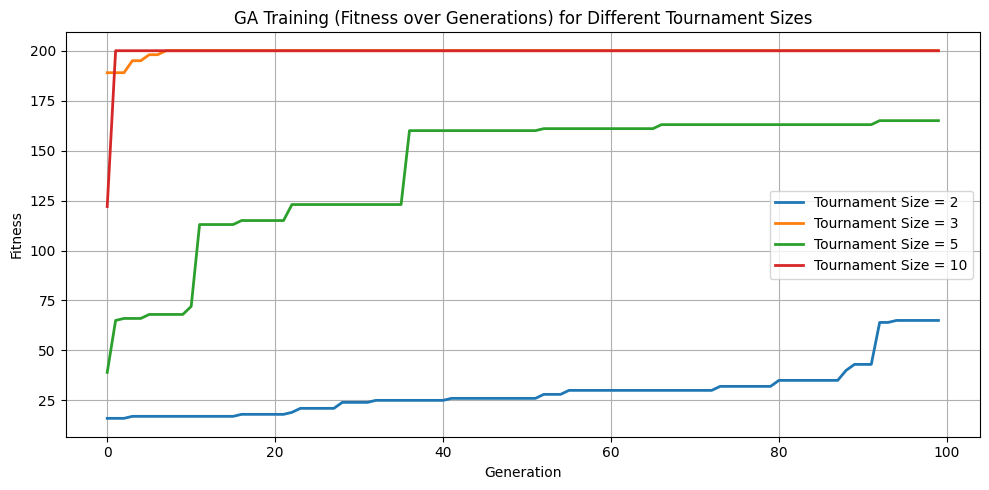

In [21]:
# cell 9c parameter testing GA tournament size

tournament_sizes = [2, 3, 5, 10]
colors = ['red', 'green', 'blue', 'orange']
fitness_curves = {}

for i, ts in enumerate(tournament_sizes):
    print(f"\nTesting GA with tournament_size = {ts}")
    env = BaseEnvironment(seed=SEED)
    solver = GASolver(env, tournament_size=ts, generations=100)
    solver.train()
    fitness_curves[ts] = solver.fitness_history
    env.close()

# Plot
plt.figure(figsize=(10, 5))
for ts, curve in fitness_curves.items():
    plt.plot(curve, label=f"Tournament Size = {ts}", linewidth=2)
plt.title("GA Training (Fitness over Generations) for Different Tournament Sizes")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training RL agent with learning rate = 0.0001
[RL] Episode 0: Reward = 63.0
[RL] Episode 50: Reward = 9.0
[RL] Episode 100: Reward = 10.0
[RL] Episode 150: Reward = 11.0
[RL] Episode 200: Reward = 12.0
[RL] Episode 250: Reward = 20.0
[RL] Episode 300: Reward = 11.0
[RL] Episode 350: Reward = 21.0
[RL] Episode 400: Reward = 16.0
[RL] Episode 450: Reward = 15.0
[RL] Episode 500: Reward = 11.0
[RL] Episode 550: Reward = 15.0
[RL] Episode 600: Reward = 24.0
[RL] Episode 650: Reward = 13.0
[RL] Episode 700: Reward = 16.0
[RL] Episode 750: Reward = 25.0
[RL] Episode 800: Reward = 9.0
[RL] Episode 850: Reward = 13.0
[RL] Episode 900: Reward = 27.0
[RL] Episode 950: Reward = 21.0
Training RL agent with learning rate = 0.001
[RL] Episode 0: Reward = 11.0
[RL] Episode 50: Reward = 19.0
[RL] Episode 100: Reward = 15.0
[RL] Episode 150: Reward = 39.0
[RL] Episode 200: Reward = 83.0
[RL] Episode 250: Reward = 49.0
[RL] Episode 300: Reward = 30.0
[RL] Episode 350: Reward = 26.0
[RL] Episode 400: Rew

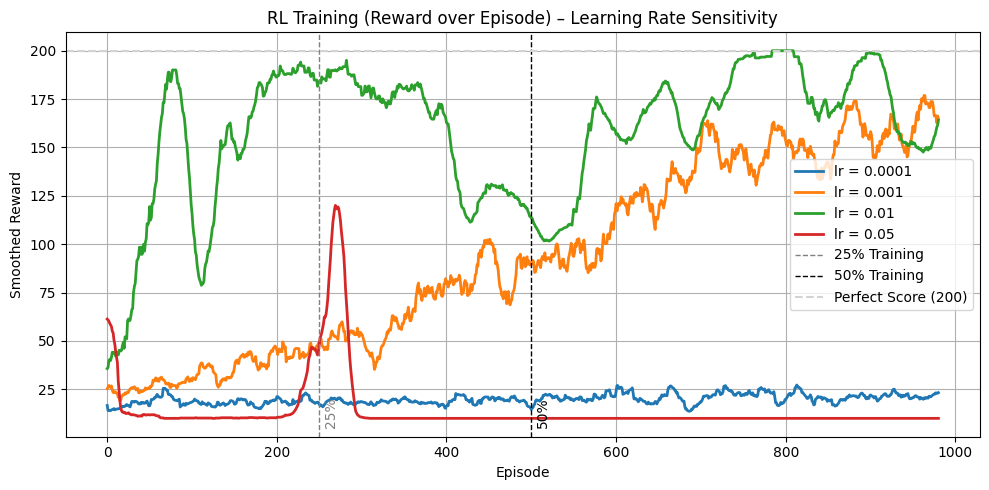

In [14]:
# cell 10a parameter testing RL learning rate

learning_rates = [1e-4, 1e-3, 1e-2, 5e-2]
episode_length = 1000
window = 20
results = {}

for lr in learning_rates:
    print(f"Training RL agent with learning rate = {lr}")

    env = BaseEnvironment(seed=SEED)
    agent = RLAgent(obs_dim=4, act_dim=2, learning_rate=lr)
    solver = RLSolver(env, agent)
    solver.train(episodes=episode_length)

    rewards = np.array(solver.reward_history)
    if len(rewards) < window:
        smoothed = rewards
    else:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')

    results[lr] = smoothed

# Plotting all smoothed reward curves with time markers
plt.figure(figsize=(10, 5))

for lr, rewards in results.items():
    plt.plot(rewards, label=f"lr = {lr}", linewidth=2)

# Time markers at 25% and 50% of episode length
x25 = int(episode_length * 0.25)
x50 = int(episode_length * 0.50)

plt.axvline(x=x25, color='gray', linestyle='--', linewidth=1, label='25% Training')
plt.axvline(x=x50, color='black', linestyle='--', linewidth=1, label='50% Training')

# Annotate the lines slightly above the bottom of the y-axis
plt.text(x25 + 5, 5, "25%", rotation=90, verticalalignment='bottom', color='gray')
plt.text(x50 + 5, 5, "50%", rotation=90, verticalalignment='bottom', color='black')


plt.axhline(y=200, color='lightgray', linestyle='--', label='Perfect Score (200)')

plt.title("RL Training (Reward over Episode) – Learning Rate Sensitivity")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training RL Agent with hidden_dim = 32
[RL] Episode 0: Reward = 29.0
[RL] Episode 50: Reward = 14.0
[RL] Episode 100: Reward = 32.0
[RL] Episode 150: Reward = 27.0
[RL] Episode 200: Reward = 45.0
[RL] Episode 250: Reward = 40.0
[RL] Episode 300: Reward = 26.0
[RL] Episode 350: Reward = 60.0
[RL] Episode 400: Reward = 86.0
[RL] Episode 450: Reward = 101.0
[RL] Episode 500: Reward = 200.0
[RL] Episode 550: Reward = 91.0
[RL] Episode 600: Reward = 200.0
[RL] Episode 650: Reward = 200.0
[RL] Episode 700: Reward = 200.0
[RL] Episode 750: Reward = 184.0
[RL] Episode 800: Reward = 181.0
[RL] Episode 850: Reward = 200.0
[RL] Episode 900: Reward = 200.0
[RL] Episode 950: Reward = 200.0

Training RL Agent with hidden_dim = 64
[RL] Episode 0: Reward = 14.0
[RL] Episode 50: Reward = 16.0
[RL] Episode 100: Reward = 50.0
[RL] Episode 150: Reward = 32.0
[RL] Episode 200: Reward = 76.0
[RL] Episode 250: Reward = 26.0
[RL] Episode 300: Reward = 127.0
[RL] Episode 350: Reward = 49.0
[RL] Episode 400: R

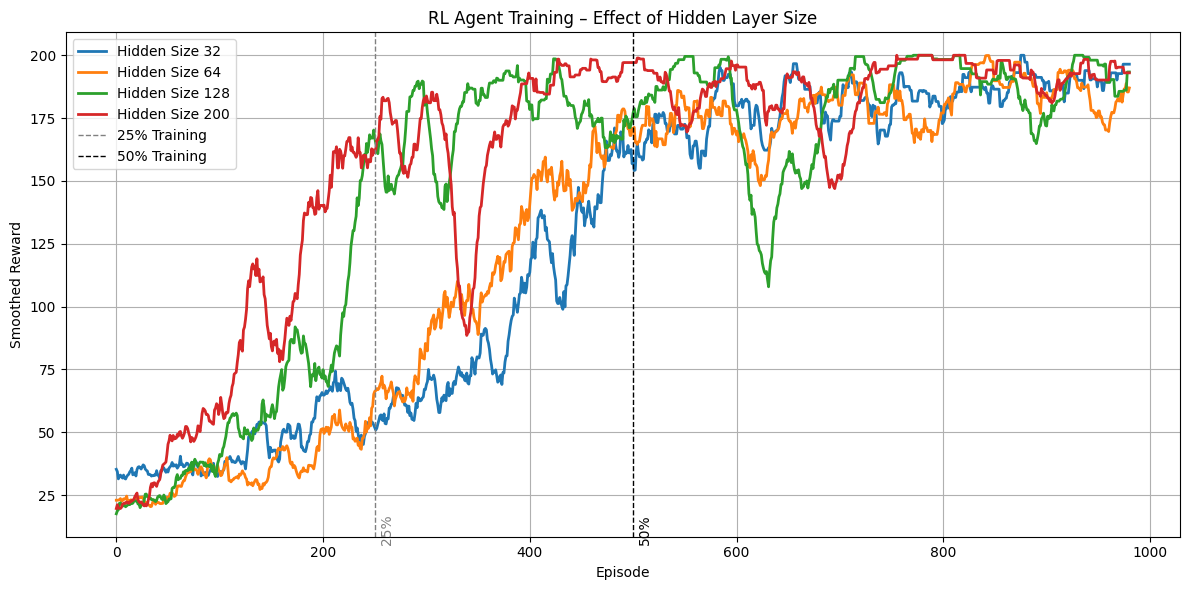

In [15]:
# cell 10b parameter testing RL hidden layer
hidden_sizes = [32, 64, 128, 200]
reward_curves = {}
window = 20

for h_size in hidden_sizes:
    print(f"\nTraining RL Agent with hidden_dim = {h_size}")
    env = BaseEnvironment(seed=SEED)
    agent = RLAgent(obs_dim=4, act_dim=2, hidden_dim=h_size)
    solver = RLSolver(env, agent)
    solver.train(episodes=1000)

    rewards = np.array(solver.reward_history)

    if len(rewards) < window:
        smoothed = rewards
    else:
        smoothed = np.convolve(rewards, np.ones(window) / window, mode='valid')

    reward_curves[h_size] = smoothed

# Plot all training curves together
plt.figure(figsize=(12, 6))
for h_size, curve in reward_curves.items():
    plt.plot(curve, label=f"Hidden Size {h_size}", linewidth=2)

# Time markers at 25% and 50% of episode length
x25 = int(episode_length * 0.25)
x50 = int(episode_length * 0.50)

plt.axvline(x=x25, color='gray', linestyle='--', linewidth=1, label='25% Training')
plt.axvline(x=x50, color='black', linestyle='--', linewidth=1, label='50% Training')

# Annotate the lines slightly above the bottom of the y-axis
plt.text(x25 + 5, 5, "25%", rotation=90, verticalalignment='bottom', color='gray')
plt.text(x50 + 5, 5, "50%", rotation=90, verticalalignment='bottom', color='black')


plt.title("RL Agent Training – Effect of Hidden Layer Size")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
